In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#Read CSV files for breast annotations, finding annotations, metadata
breast_annotations = pd.read_csv("breast-level_annotations.csv")
finding_annotations = pd.read_csv("finding_annotations.csv")
metadata = pd.read_csv("metadata.csv")

#Standardize col names
breast_annotations.rename(columns={"breast_birads": "BI-RADS", "view_position": "View Position", "laterality": "Laterality", "breast_density": "Breast Density"}, inplace=True)
metadata.rename(columns={"Patient's Age": "Age"}, inplace=True)

#Merge datasets on image_id
merged_df = breast_annotations.merge(metadata, left_on="image_id", right_on="SOP Instance UID", how="left")
merged_df = merged_df.merge(finding_annotations, on="image_id", how="left")
selected_columns = ["image_id", "BI-RADS", "Age", "View Position_x", "Laterality", "Breast Density"]
merged_df = merged_df[selected_columns]
merged_df.rename(columns={"View Position_x": "View Position"}, inplace=True)

#Convert BI-RADS to binary target
merged_df["target"] = merged_df["BI-RADS"].apply(lambda x: 0 if x == "BI-RADS 1" else 1)

#Encode categorical cols with label encoder; save encoders
label_encoders = {}
for col in ["View Position", "Laterality", "Breast Density"]:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le  # Save for later use

#Fix Age: remove 'Y', make numeric, fill missing with median, convert to int
merged_df["Age"] = pd.to_numeric(merged_df["Age"].astype(str).str.replace("Y", "", regex=False), errors="coerce")
merged_df["Age"] = merged_df["Age"].fillna(merged_df["Age"].median())  # Explicit assignment
merged_df["Age"] = merged_df["Age"].astype(int)
merged_df.drop(columns=["BI-RADS"], inplace=True)

merged_df.to_csv("processed_data.csv", index=False)
print("Processed dataset saved as 'processed_data.csv'")

print(merged_df.head())

Processed dataset saved as 'processed_data.csv'
                           image_id  Age  View Position  Laterality  \
0  d8125545210c08e1b1793a5af6458ee2   53              0           0   
1  290c658f4e75a3f83ec78a847414297c   53              1           0   
2  cd0fc7bc53ac632a11643ac4cc91002a   53              0           1   
3  71638b1e853799f227492bfb08a01491   53              1           1   
4  dd9ce3288c0773e006a294188aadba8e   42              0           0   

   Breast Density  target  
0               2       1  
1               2       1  
2               2       1  
3               2       1  
4               2       0  


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv("processed_data.csv")

#Set features (X) and target (y)
X = df.drop(columns=["image_id", "target"])  # Remove non-numeric columns
y = df["target"]

#Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Standardize numeric feature (Age)
scaler = StandardScaler()
X_train["Age"] = scaler.fit_transform(X_train[["Age"]])
X_test["Age"] = scaler.transform(X_test[["Age"]])

#Set up models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "k-NN": KNeighborsClassifier()
}

#Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Report": report
    }

for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print("Classification Report:\n", metrics["Report"])
    print("-" * 50)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Logistic Regression
Accuracy: 0.6545
Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      2682
           1       0.00      0.00      0.00      1416

    accuracy                           0.65      4098
   macro avg       0.33      0.50      0.40      4098
weighted avg       0.43      0.65      0.52      4098

--------------------------------------------------
Model: SVM
Accuracy: 0.6640
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.99      0.79      2682
           1       0.68      0.05      0.10      1416

    accuracy                           0.66      4098
   macro avg       0.67      0.52      0.44      4098
weighted avg       0.67      0.66      0.55      4098

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.6664
Classification Report:
               precision    recall  f1-score   support

       

In [3]:
import pandas as pd
import os

breast_annotations = pd.read_csv("breast-level_annotations.csv")
unique_series_ids = breast_annotations["study_id"].unique()

#Get list of folders in images3/
image_folder_path = "images3"
image_folders = os.listdir(image_folder_path)
matching_series = [series_id for series_id in unique_series_ids if str(series_id) in image_folders]

print(f"Total Unique Series IDs in CSV: {len(unique_series_ids)}")
print(f"Total Image Folders: {len(image_folders)}")
print(f"Matching Series IDs: {len(matching_series)} / {len(unique_series_ids)}")
missing_series = [series_id for series_id in unique_series_ids if str(series_id) not in image_folders]
print(f"Example missing series IDs: {missing_series[:5]}")


Total Unique Series IDs in CSV: 5000
Total Image Folders: 5001
Matching Series IDs: 5000 / 5000
Example missing series IDs: []


In [4]:
import cv2
import numpy as np
import os
import pandas as pd

# Define image size
IMG_SIZE = (224, 224)
breast_annotations = pd.read_csv("breast-level_annotations.csv")

#Mapping from image_id to study_id
image_id_to_study = dict(zip(breast_annotations["image_id"], breast_annotations["study_id"]))
image_folder_path = "images3"

def load_image(image_id):
    """Loads an image using study_id as folder and image_id as filename."""
    study_id = image_id_to_study.get(image_id, None)  
    
    if study_id is None:
        print(f"❌ No study_id found for image_id: {image_id}")
        return np.zeros(IMG_SIZE[0] * IMG_SIZE[1])  
    
    #Full path to the image
    image_path = os.path.join(image_folder_path, str(study_id), f"{image_id}.jpg")
    
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return np.zeros(IMG_SIZE[0] * IMG_SIZE[1])  
    
    #Load
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    
    if image is None:
        print(f"❌ Failed to load image: {image_path}")
        return np.zeros(IMG_SIZE[0] * IMG_SIZE[1])  
    
    #Resize, normalize, and flatten
    image = cv2.resize(image, IMG_SIZE)  
    image = image.flatten() / 255.0  
    
    #Print only a few successful loads
    if np.random.rand() < 0.001:
        print(f"✅ Successfully loaded: {image_path}")
    
    return image


In [5]:
df = pd.read_csv("processed_data.csv")  
image_features = np.array([load_image(image_id) for image_id in df["image_id"]])
np.save("image-features.npy", image_features)
print("✅ Image features saved successfully as 'image_features.npy'")


❌ Failed to load image: images3/2d80c57224957fc549957e28fbe00a96/10fdb3727c2284f8a62728a5a377e64a.jpg
❌ Failed to load image: images3/d20e854e243eb765409347b523b5af8f/b9e0699d03f5f5e3ea93bb77b76290e7.jpg
❌ Failed to load image: images3/d20e854e243eb765409347b523b5af8f/9be3ba5c18018eea5170ea4fdfb433fd.jpg
❌ Failed to load image: images3/b3c00c949e5dba771bb225644f667b8a/0ea0230273cd82a016b0a7de30d2a0cc.jpg
❌ Failed to load image: images3/b3c00c949e5dba771bb225644f667b8a/9e1fc8b0627b409cc3281643023f4b3d.jpg
❌ Failed to load image: images3/64a11835afeab324c3161f08e21e0f8e/b5be8bf327e235066f65081f6636664c.jpg
❌ Failed to load image: images3/a6fe0f9f92810debf4f086815cee72d2/051144a61d3f6288c36bbd79be5a0a96.jpg
❌ Failed to load image: images3/a6fe0f9f92810debf4f086815cee72d2/d57cc8b898821490662e792804057265.jpg
❌ Failed to load image: images3/e918d30cfad5b412496285cc3f49d582/b29708792468e2e3916d0f0bd683a2cc.jpg
❌ Failed to load image: images3/e918d30cfad5b412496285cc3f49d582/fae50db4b8bfc26e8

In [2]:
import numpy as np
import pandas as pd

X_images = np.load("image-features.npy")
df = pd.read_csv("processed_data.csv")
y = df["target"].values

#Checking the transition
print(f"Image Features Shape: {X_images.shape}")
print(f"Labels Shape: {y.shape}")
print("First 3 Image Features:")
print(X_images[:3])

Image Features Shape: (20486, 50176)
Labels Shape: (20486,)
First 3 Image Features:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.63921569 0.65490196 0.61960784 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [18]:
import numpy as np
import pandas as pd

X_images = np.load("image-features-aligned.npy")
df = pd.read_csv("processed_data_aligned.csv")
y_labels = df["target"].values  
assert X_images.shape[0] == len(y_labels), "⚠️ Features and labels are not aligned!"

#Merge features with labels
dataset = np.column_stack((X_images, y_labels))
np.save("image-dataset-with-labels.npy", dataset)
print(f"✅ Merged dataset saved. New shape: {dataset.shape}")


✅ Merged dataset saved. New shape: (20486, 50177)


In [2]:
import numpy as np
import pandas as pd

dataset = np.load("image-dataset-with-labels.npy")
np.random.seed(42)
num_samples = int(dataset.shape[0] * 0.7)  #70% of data
selected_indices = np.random.choice(dataset.shape[0], num_samples, replace=False)
dataset_reduced = dataset[selected_indices]
np.save("image-dataset-reduced.npy", dataset_reduced)

print(f"✅ Reduced dataset saved. New shape: {dataset_reduced.shape}")


✅ Reduced dataset saved. New shape: (14340, 50177)


In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

dataset_reduced = np.load("image-dataset-reduced.npy")
X_images_reduced = dataset_reduced[:, :-1]
y_reduced = dataset_reduced[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X_images_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced
)

#PCA
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
np.save("X_train_pca.npy", X_train_pca)
np.save("X_test_pca.npy", X_test_pca)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print(f"✅ PCA Completed. Transformed Feature Shape: {X_train_pca.shape}")


✅ PCA Completed. Transformed Feature Shape: (11472, 300)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train_pca = np.load("X_train_pca.npy")
X_test_pca = np.load("X_test_pca.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

#Train Logistic Regression
log_reg = LogisticRegression(max_iter=500, solver="saga", n_jobs=-1, warm_start=True)
log_reg.fit(X_train_pca, y_train)
y_pred = log_reg.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Logistic Regression Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


✅ Logistic Regression Accuracy: 0.6586
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.95      0.79      1889
         1.0       0.50      0.09      0.16       979

    accuracy                           0.66      2868
   macro avg       0.58      0.52      0.47      2868
weighted avg       0.61      0.66      0.57      2868



In [16]:
import optuna
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

#Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

#Fixed Search Space with Valid Solver-Penalty Pairs
valid_solver_penalty = [
    ("saga", "l1"), ("saga", "l2"), ("saga", "elasticnet"),
    ("liblinear", "l1"), ("liblinear", "l2"),
    ("sag", "l2")
]

def objective(trial):
    C = trial.suggest_float("C", 0.0001, 1000, log=True)  # Regularization strength
    solver, penalty = trial.suggest_categorical("solver_penalty", valid_solver_penalty)  # Predefined valid pairs

    #Handle ElasticNet
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0) if penalty == "elasticnet" else None

    #Apply SMOTE to Balance Classes
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

    #Convert y_resampled to int for np.bincount
    y_resampled = y_resampled.astype(int)

    print(f"✅ SMOTE Applied: New Training Set Shape: {X_resampled.shape}, Labels: {np.bincount(y_resampled)}")
    model = LogisticRegression(
        C=C, solver=solver, penalty=penalty, class_weight="balanced",
        max_iter=1000, n_jobs=-1, l1_ratio=l1_ratio
    )

    #Cross-validation to evaluate accuracy
    score = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring="accuracy").mean()
    
    return score

#Run Optuna
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=40)  #Trials for better tuning
best_params = study.best_params
best_solver, best_penalty = best_params["solver_penalty"]

print(f"✅ Best Parameters (Optuna Fixed + SMOTE): {best_params}")
print(f"✅ Best Accuracy (Optuna Fixed + SMOTE): {study.best_value:.4f}")

#Final Model Training on Best Parameters
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
y_train_resampled = y_train_resampled.astype(int)

best_log_reg = LogisticRegression(
    C=best_params["C"], solver=best_solver, penalty=best_penalty,
    class_weight="balanced", max_iter=1000, n_jobs=-1,
    l1_ratio=best_params.get("l1_ratio", None)
)

best_log_reg.fit(X_train_resampled, y_train_resampled)  # Train on balanced dataset
y_pred_best = best_log_reg.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f"✅ Final Tuned Logistic Regression Accuracy (SMOTE Applied): {accuracy_best:.4f}")
print("✅ Final Classification Report:\n", classification_report(y_test, y_pred_best))


[I 2025-02-23 19:09:09,441] A new study created in memory with name: no-name-27a2de0b-d316-4a11-9689-f8524f1af363
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/opt

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:11,820] Trial 0 finished with value: 0.5698986205320751 and parameters: {'C': 20.829473676740083, 'solver_penalty': ('saga', 'l2')}. Best is trial 0 with value: 0.5698986205320751.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:14,009] Trial 1 finished with value: 0.5682440652034041 and parameters: {'C': 0.0017508117127077955, 'solver_penalty': ('saga', 'l2')}. Best is trial 0 with value: 0.5698986205320751.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:21,817] Trial 6 finished with value: 0.5699647580547462 and parameters: {'C': 0.631007542185309, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.6713484960520228}. Best is trial 6 with value: 0.5699647580547462.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but co

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:24,752] Trial 7 finished with value: 0.5697000765214862 and parameters: {'C': 0.017005582400300423, 'solver_penalty': ('sag', 'l2')}. Best is trial 6 with value: 0.5699647580547462.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:28,775] Trial 9 finished with value: 0.5683763840629383 and parameters: {'C': 0.07698580187069916, 'solver_penalty': ('saga', 'l1')}. Best is trial 6 with value: 0.5699647580547462.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:29,718] Trial 10 finished with value: 0.5000662032439589 and parameters: {'C': 0.00014595994837445937, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.6176430121262659}. Best is trial 6 with value: 0.5699647580547462.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:32,629] Trial 11 finished with value: 0.5700309393916093 and parameters: {'C': 0.7909622373051638, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9654646017730972}. Best is trial 11 with value: 0.5700309393916093.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:35,547] Trial 12 finished with value: 0.5699646923334585 and parameters: {'C': 0.6770613199701057, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9859401088766027}. Best is trial 11 with value: 0.5700309393916093.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:38,662] Trial 13 finished with value: 0.5702294395880063 and parameters: {'C': 0.4566463203883709, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9191862512529112}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:41,530] Trial 14 finished with value: 0.5658605293499221 and parameters: {'C': 0.030945759122803472, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9917312903593032}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage b

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:44,547] Trial 15 finished with value: 0.5695014886967054 and parameters: {'C': 0.22590181229831988, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.10057090413212016}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage b

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:46,279] Trial 16 finished with value: 0.502979145978153 and parameters: {'C': 0.0031002918425298413, 'solver_penalty': ('saga', 'l1')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:49,217] Trial 17 finished with value: 0.5698986205320751 and parameters: {'C': 3.0836415543917854, 'solver_penalty': ('sag', 'l2')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:52,171] Trial 18 finished with value: 0.5698324172881162 and parameters: {'C': 54.39662952110419, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.7880578529801123}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:55,196] Trial 19 finished with value: 0.5698324391952121 and parameters: {'C': 0.4860504936791776, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.391501877229841}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:09:57,725] Trial 20 finished with value: 0.5445470937936978 and parameters: {'C': 0.005183543756161017, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.8240648039391663}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage b

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:00,778] Trial 21 finished with value: 0.5697000546143902 and parameters: {'C': 1.1613193303167606, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.794852282582311}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:03,875] Trial 22 finished with value: 0.5681115272729105 and parameters: {'C': 0.09922840510618569, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.5960663943614023}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage bu

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:06,867] Trial 23 finished with value: 0.5696338732775272 and parameters: {'C': 1.3700686662873616, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.8839623381858871}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:09,827] Trial 24 finished with value: 0.5697662140441573 and parameters: {'C': 12.233457376063942, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.6819615154966792}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:12,827] Trial 25 finished with value: 0.5697662359512533 and parameters: {'C': 0.22354489933920824, 'solver_penalty': ('sag', 'l2')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which i

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:16,600] Trial 27 finished with value: 0.5685085714798965 and parameters: {'C': 0.09634711297265651, 'solver_penalty': ('saga', 'l1')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:18,930] Trial 28 finished with value: 0.5698324172881162 and parameters: {'C': 1.5319419998027548, 'solver_penalty': ('saga', 'l2')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which i

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:21,309] Trial 29 finished with value: 0.5698324172881162 and parameters: {'C': 31.05232682694059, 'solver_penalty': ('saga', 'l2')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:24,278] Trial 30 finished with value: 0.5698986205320751 and parameters: {'C': 165.6391479471606, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.4546758671559349}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:27,294] Trial 31 finished with value: 0.5699646923334585 and parameters: {'C': 0.6708331311122674, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9971060580690851}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:30,198] Trial 32 finished with value: 0.5698324172881162 and parameters: {'C': 9.642240217325583, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9110365038990479}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:33,251] Trial 33 finished with value: 0.5696338294633352 and parameters: {'C': 0.25444265089040147, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9311851248004306}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage bu

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:35,763] Trial 34 finished with value: 0.5698986205320751 and parameters: {'C': 2.2210148587928895, 'solver_penalty': ('saga', 'l2')}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which i

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:40,025] Trial 36 finished with value: 0.5681116149012942 and parameters: {'C': 0.05460599505670376, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.7180254208854782}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage bu

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


[I 2025-02-23 19:10:41,752] Trial 38 finished with value: 0.5 and parameters: {'C': 0.0004075167271656324, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9062441075735803}. Best is trial 13 with value: 0.5702294395880063.
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('

✅ SMOTE Applied: New Training Set Shape: (15108, 300), Labels: [7554 7554]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

✅ Best Parameters (Optuna Fixed + SMOTE): {'C': 0.4566463203883709, 'solver_penalty': ('saga', 'elasticnet'), 'l1_ratio': 0.9191862512529112}
✅ Best Accuracy (Optuna Fixed + SMOTE): 0.5702
✅ Final Tuned Logistic Regression Accuracy (SMOTE Applied): 0.5272
✅ Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.55      0.61      1889
         1.0       0.36      0.48      0.41       979

    accuracy                           0.53      2868
   macro avg       0.51      0.52      0.51      2868
weighted avg       0.56      0.53      0.54      2868



In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train_pca = np.load("X_train_pca.npy")
X_test_pca = np.load("X_test_pca.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

#SMOTE to Balance Classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print(f"✅ Training Set Shape After SMOTE: {X_train_resampled.shape}")
print(f"✅ Class Distribution After SMOTE: {np.bincount(y_train_resampled.astype(int))}")

#Train Basic SVM
svm_clf = SVC(kernel='rbf', C=1.0, class_weight="balanced", random_state=42)
svm_clf.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_clf.predict(X_test_pca)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"✅ SVM Accuracy (With PCA, No Hyperparameter Tuning): {accuracy_svm:.4f}")
print("✅ Classification Report:\n", classification_report(y_test, y_pred_svm))


✅ Training Set Shape After SMOTE: (15108, 300)
✅ Class Distribution After SMOTE: [7554 7554]
✅ SVM Accuracy (With PCA, No Hyperparameter Tuning): 0.5607
✅ Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.62      0.65      1889
         1.0       0.38      0.45      0.41       979

    accuracy                           0.56      2868
   macro avg       0.53      0.54      0.53      2868
weighted avg       0.58      0.56      0.57      2868



In [2]:
import optuna
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

def objective(trial):
    C = trial.suggest_float("C", 0.0001, 1000, log=True)  # SVM regularization
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])  # Kernel coefficient

    model = SVC(C=C, kernel=kernel, gamma=gamma, class_weight="balanced", random_state=42)

    #Cross-validation for accuracy
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring="accuracy").mean()
    
    return score

#Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=4)

best_params_svm = study.best_params
print(f"✅ Best SVM Parameters: {best_params_svm}")
print(f"✅ Best SVM Accuracy (Optuna): {study.best_value:.4f}")

#Train Final SVM Model
best_svm = SVC(
    C=best_params_svm["C"], kernel=best_params_svm["kernel"], gamma=best_params_svm["gamma"],
    class_weight="balanced", random_state=42
)

best_svm.fit(X_train_resampled, y_train_resampled)
y_pred_best_svm = best_svm.predict(X_test_pca)
accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
print(f"✅ Final Tuned SVM Accuracy (With PCA): {accuracy_best_svm:.4f}")
print("✅ Final Classification Report:\n", classification_report(y_test, y_pred_best_svm))


[I 2025-02-23 17:27:42,445] A new study created in memory with name: no-name-a092ee13-2c37-489b-bfe6-2e5638537ae4
[I 2025-02-23 17:30:27,058] Trial 0 finished with value: 0.5307092137521356 and parameters: {'C': 0.013966587479225454, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.5307092137521356.
[I 2025-02-23 17:33:01,878] Trial 1 finished with value: 0.640525783447042 and parameters: {'C': 0.026445524645091947, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 1 with value: 0.640525783447042.
[I 2025-02-23 17:34:40,833] Trial 2 finished with value: 0.5035064935918458 and parameters: {'C': 25.668200401590287, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 1 with value: 0.640525783447042.
[I 2025-02-23 17:36:56,235] Trial 3 finished with value: 0.5632790628845379 and parameters: {'C': 0.027112701350033394, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.640525783447042.


✅ Best SVM Parameters: {'C': 0.026445524645091947, 'kernel': 'poly', 'gamma': 'auto'}
✅ Best SVM Accuracy (Optuna): 0.6405
✅ Final Tuned SVM Accuracy (With PCA): 0.5771
✅ Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.64      0.66      1889
         1.0       0.40      0.46      0.43       979

    accuracy                           0.58      2868
   macro avg       0.55      0.55      0.55      2868
weighted avg       0.59      0.58      0.58      2868



In [4]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train_pca = np.load("X_train_pca.npy")
X_test_pca = np.load("X_test_pca.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

#SMOTE to Balance Classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print(f"✅ Training Set Shape After SMOTE: {X_train_resampled.shape}")
print(f"✅ Class Distribution After SMOTE: {np.bincount(y_train_resampled.astype(int))}")

#Train Basic Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_clf.predict(X_test_pca)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"✅ Decision Tree Accuracy (No Tuning): {accuracy_dt:.4f}")
print("✅ Classification Report:\n", classification_report(y_test, y_pred_dt))


✅ Training Set Shape After SMOTE: (15108, 300)
✅ Class Distribution After SMOTE: [7554 7554]
✅ Decision Tree Accuracy (No Tuning): 0.5732
✅ Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.63      0.66      1889
         1.0       0.39      0.46      0.43       979

    accuracy                           0.57      2868
   macro avg       0.54      0.55      0.54      2868
weighted avg       0.59      0.57      0.58      2868



In [5]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 50)  # Limits tree depth
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Min samples for split
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)  # Min samples for leaf node
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])  # Split quality metric

    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, criterion=criterion, random_state=42
    )

    #Cross-validation for accuracy
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring="accuracy").mean()
    
    return score

#Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

best_params_dt = study.best_params
print(f"✅ Best Decision Tree Parameters: {best_params_dt}")
print(f"✅ Best Decision Tree Accuracy (Optuna): {study.best_value:.4f}")

#Train Final Decision Tree Model
best_dt = DecisionTreeClassifier(
    max_depth=best_params_dt["max_depth"],
    min_samples_split=best_params_dt["min_samples_split"],
    min_samples_leaf=best_params_dt["min_samples_leaf"],
    criterion=best_params_dt["criterion"],
    random_state=42
)

best_dt.fit(X_train_resampled, y_train_resampled)
y_pred_best_dt = best_dt.predict(X_test_pca)

accuracy_best_dt = accuracy_score(y_test, y_pred_best_dt)
print(f"✅ Final Tuned Decision Tree Accuracy: {accuracy_best_dt:.4f}")
print("✅ Final Classification Report:\n", classification_report(y_test, y_pred_best_dt))


[I 2025-02-23 17:41:21,407] A new study created in memory with name: no-name-c2377761-7665-477c-98c3-f5a13e403eff
[I 2025-02-23 17:41:43,754] Trial 0 finished with value: 0.6213311145826557 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.6213311145826557.
[I 2025-02-23 17:42:07,218] Trial 1 finished with value: 0.6255668515844636 and parameters: {'max_depth': 39, 'min_samples_split': 9, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 1 with value: 0.6255668515844636.
[I 2025-02-23 17:42:36,861] Trial 2 finished with value: 0.6150433837174633 and parameters: {'max_depth': 36, 'min_samples_split': 18, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6255668515844636.
[I 2025-02-23 17:42:43,727] Trial 3 finished with value: 0.5376008356242679 and parameters: {'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with 

✅ Best Decision Tree Parameters: {'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy'}
✅ Best Decision Tree Accuracy (Optuna): 0.6345
✅ Final Tuned Decision Tree Accuracy: 0.5614
✅ Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.61      0.65      1889
         1.0       0.38      0.46      0.42       979

    accuracy                           0.56      2868
   macro avg       0.53      0.54      0.53      2868
weighted avg       0.58      0.56      0.57      2868



In [18]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train_pca = np.load("X_train_pca.npy")
X_test_pca = np.load("X_test_pca.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

#SMOTE to Balance Classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print(f"✅ Training Set Shape After SMOTE: {X_train_resampled.shape}")
print(f"✅ Class Distribution After SMOTE: {np.bincount(y_train_resampled.astype(int))}")

#Train Basic Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_clf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_clf.predict(X_test_pca)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"✅ Random Forest Accuracy (No Tuning): {accuracy_rf:.4f}")
print("✅ Classification Report:\n", classification_report(y_test, y_pred_rf))


✅ Training Set Shape After SMOTE: (15108, 300)
✅ Class Distribution After SMOTE: [7554 7554]
✅ Random Forest Accuracy (No Tuning): 0.6433
✅ Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.86      0.76      1889
         1.0       0.46      0.23      0.31       979

    accuracy                           0.64      2868
   macro avg       0.57      0.54      0.53      2868
weighted avg       0.60      0.64      0.60      2868



In [19]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)  # Number of trees
    max_depth = trial.suggest_int("max_depth", 5, 50)  # Limits tree depth
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  # Min samples for split
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)  # Min samples for leaf node
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])  # Split quality metric

    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, criterion=criterion, class_weight="balanced",
        random_state=42, n_jobs=-1
    )

    #Cross-validation for accuracy
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring="accuracy", n_jobs=-1).mean()
    
    return score

#Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
best_params_rf = study.best_params
print(f"✅ Best Random Forest Parameters: {best_params_rf}")
print(f"✅ Best Random Forest Accuracy (Optuna): {study.best_value:.4f}")

#Train Final Random Forest Model
best_rf = RandomForestClassifier(
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    min_samples_split=best_params_rf["min_samples_split"],
    min_samples_leaf=best_params_rf["min_samples_leaf"],
    criterion=best_params_rf["criterion"],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train_resampled, y_train_resampled)
y_pred_best_rf = best_rf.predict(X_test_pca)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"✅ Final Tuned Random Forest Accuracy: {accuracy_best_rf:.4f}")
print("✅ Final Classification Report:\n", classification_report(y_test, y_pred_best_rf))


[I 2025-02-23 19:11:49,598] A new study created in memory with name: no-name-5506207a-f537-4ad8-be82-9562e3b8ceb5
[I 2025-02-23 19:12:27,354] Trial 0 finished with value: 0.7732469010769747 and parameters: {'n_estimators': 176, 'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7732469010769747.
[I 2025-02-23 19:12:43,228] Trial 1 finished with value: 0.764772272451542 and parameters: {'n_estimators': 87, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.7732469010769747.
[I 2025-02-23 19:13:52,164] Trial 2 finished with value: 0.7938976469807312 and parameters: {'n_estimators': 269, 'max_depth': 41, 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7938976469807312.
[I 2025-02-23 19:14:37,857] Trial 3 finished with value: 0.7736430032788351 and parameters: {'n_estimators': 190, 'max_depth': 21, 'min

✅ Best Random Forest Parameters: {'n_estimators': 295, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'entropy'}
✅ Best Random Forest Accuracy (Optuna): 0.8056
✅ Final Tuned Random Forest Accuracy: 0.6583
✅ Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.87      0.77      1889
         1.0       0.50      0.26      0.34       979

    accuracy                           0.66      2868
   macro avg       0.60      0.56      0.55      2868
weighted avg       0.63      0.66      0.62      2868



In [10]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train_pca = np.load("X_train_pca.npy")
X_test_pca = np.load("X_test_pca.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

#SMOTE to Balance Classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print(f"✅ Training Set Shape After SMOTE: {X_train_resampled.shape}")
print(f"✅ Class Distribution After SMOTE: {np.bincount(y_train_resampled.astype(int))}")

#Train Basic k-NN
knn_clf = KNeighborsClassifier(n_neighbors=10, n_jobs=-1) 
knn_clf.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_clf.predict(X_test_pca)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"✅ k-NN Accuracy (No Tuning): {accuracy_knn:.4f}")
print("✅ Classification Report:\n", classification_report(y_test, y_pred_knn))


✅ Training Set Shape After SMOTE: (15108, 300)
✅ Class Distribution After SMOTE: [7554 7554]
✅ k-NN Accuracy (No Tuning): 0.5293
✅ Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.55      0.60      1889
         1.0       0.36      0.50      0.42       979

    accuracy                           0.53      2868
   macro avg       0.52      0.52      0.51      2868
weighted avg       0.57      0.53      0.54      2868



In [11]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 15)  # Limit k-values
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])  # Weighting method
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])  # Distance metric

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric, n_jobs=-1)

    #Cross-validation for accuracy
    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring="accuracy", n_jobs=-1).mean()
    
    return score

#Run Optuna Optimization (Only 10 Trials to Avoid Overload)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params_knn = study.best_params
print(f"✅ Best k-NN Parameters: {best_params_knn}")
print(f"✅ Best k-NN Accuracy (Optuna): {study.best_value:.4f}")

#Train Final k-NN Model
best_knn = KNeighborsClassifier(
    n_neighbors=best_params_knn["n_neighbors"],
    weights=best_params_knn["weights"],
    metric=best_params_knn["metric"],
    n_jobs=-1
)

best_knn.fit(X_train_resampled, y_train_resampled)
y_pred_best_knn = best_knn.predict(X_test_pca)

accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f"✅ Final Tuned k-NN Accuracy: {accuracy_best_knn:.4f}")
print("✅ Final Classification Report:\n", classification_report(y_test, y_pred_best_knn))


[I 2025-02-23 17:57:29,600] A new study created in memory with name: no-name-16b024a6-9963-41af-a446-42a265c21d68
[I 2025-02-23 17:57:40,956] Trial 0 finished with value: 0.6519062748212867 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6519062748212867.
[I 2025-02-23 17:57:51,691] Trial 1 finished with value: 0.641580619539317 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.6519062748212867.
[I 2025-02-23 17:57:53,034] Trial 2 finished with value: 0.5839290442149855 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6519062748212867.
[I 2025-02-23 17:58:03,447] Trial 3 finished with value: 0.6642176330420969 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 3 with value: 0.6642176330420969.
[I 2025-02-23 17:58:04,850] Trial 4 finished with value: 0.6696

✅ Best k-NN Parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski'}
✅ Best k-NN Accuracy (Optuna): 0.6696
✅ Final Tuned k-NN Accuracy: 0.5199
✅ Final Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.49      0.57      1889
         1.0       0.37      0.58      0.45       979

    accuracy                           0.52      2868
   macro avg       0.53      0.53      0.51      2868
weighted avg       0.58      0.52      0.53      2868



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

X_test_pca = np.load("X_test_pca.npy")
y_test = np.load("y_test.npy")
models = {
    "Logistic Regression": best_log_reg,
    "SVM": best_svm,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "k-NN": best_knn
}

y_scores = {}  #Store probability scores for ROC-AUC
y_preds = {}   #Store final predictions


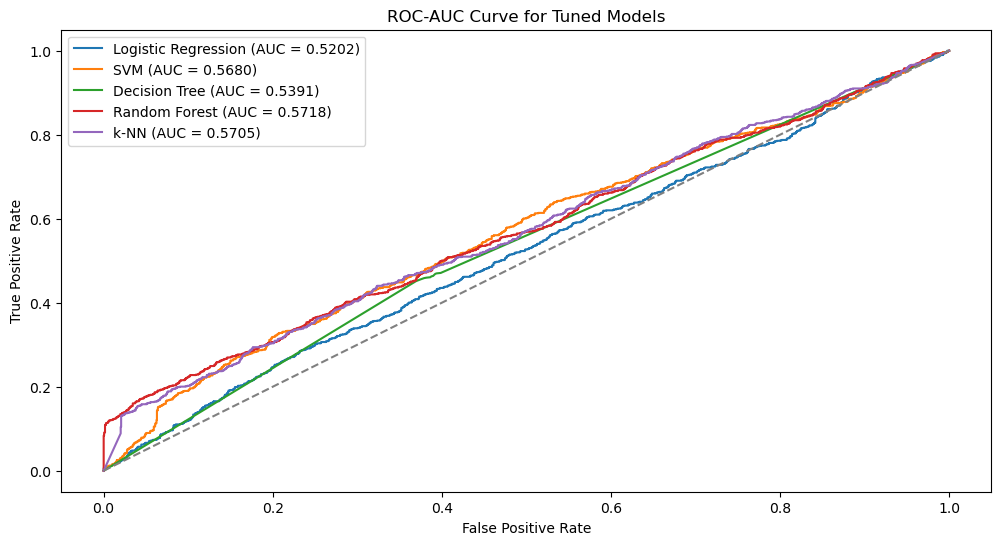

In [21]:
plt.figure(figsize=(12, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores[name] = model.predict_proba(X_test_pca)[:, 1]  # Probabilities for class 1
    else:
        y_scores[name] = model.decision_function(X_test_pca)  # SVM uses decision_function

    #Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_scores[name])
    roc_auc = auc(fpr, tpr)

    #Plot ROC Curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
    y_preds[name] = model.predict(X_test_pca)

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Tuned Models")
plt.legend()
plt.show()


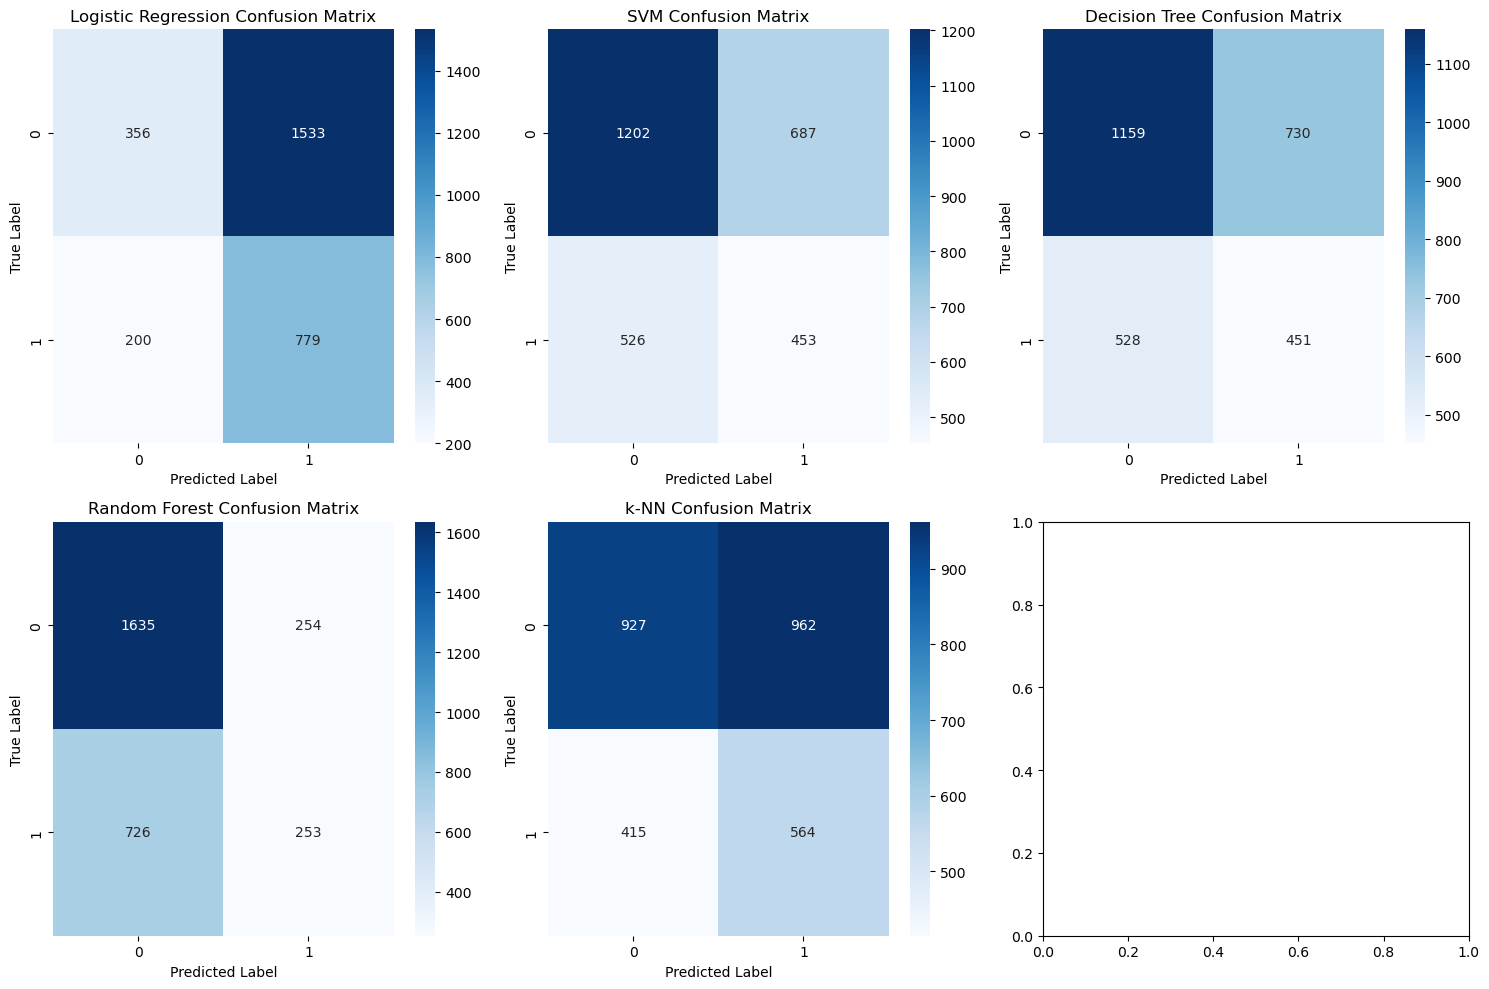

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

for idx, (name, y_pred) in enumerate(y_preds.items()):
    cm = confusion_matrix(y_test, y_pred)

    ax = axes[idx // 3, idx % 3]  # Place in grid
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()
